In [1]:
# https://www.tensorflow.org/tutorials/images/segmentation

from fastai.vision.all import *
# %% [markdown]
# images
path = Path(".").absolute().parent / "data/train"
test_path = path.parent/'test'
fnames = get_image_files(path/"images")
print('example file name:', fnames[0])
print('of', len(fnames), 'training examples')

example file name: D:\Dev\hedgehog_finder\data\train\images\1\1.png
of 301 training examples


## Define DataLoaders

In [2]:
from hedgiefinder.dataloading import get_msk

codes = ['Background', 'Hog', 'Outline']

def get_dls_no_norm(bs=10, size=224):
    hogvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                       get_items=get_image_files,
                       splitter=RandomSplitter(),
                       get_y=get_msk,
                       batch_tfms=[*aug_transforms(do_flip=False, max_rotate=2)],
                       item_tfms=Resize(size, method='squish'))

    return hogvid.dataloaders(path / "images", path=path, bs=bs)

def get_dls_norm(bs=10, size=224):
    hogvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                       get_items=get_image_files,
                       splitter=RandomSplitter(),
                       get_y=get_msk,
                       batch_tfms=[*aug_transforms(do_flip=False, max_rotate=2),  Normalize.from_stats(*imagenet_stats)],
                       item_tfms=Resize(size, method='squish'))

    return hogvid.dataloaders(path / "images", path=path, bs=bs)

## Baseline without normalization

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


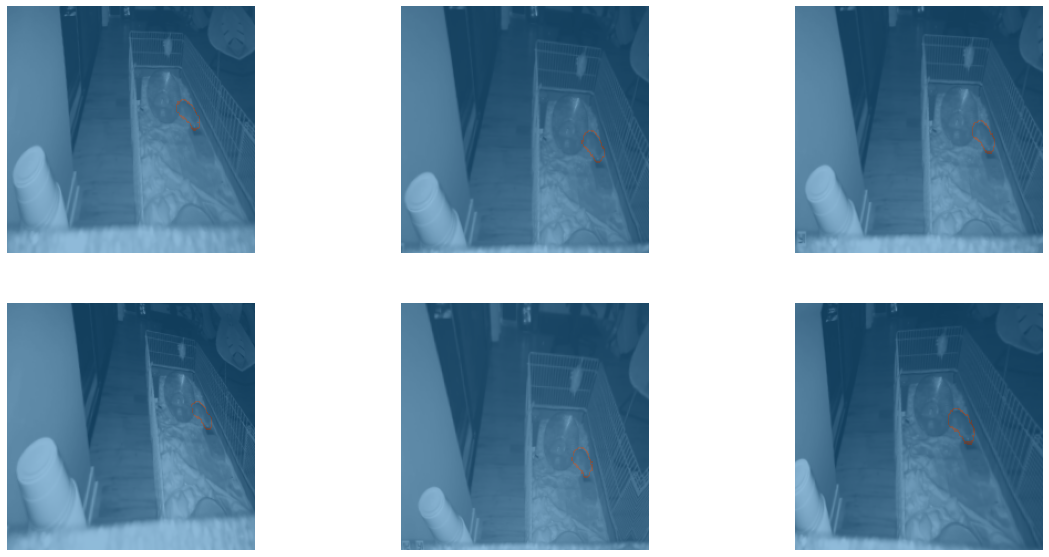

In [3]:
dls = get_dls_no_norm(8, 224)
dls.show_batch(max_n=6, unique=True, figsize=(20,10))

epoch,train_loss,valid_loss,foreground_acc,time
0,0.104886,0.038029,0.000000,00:41


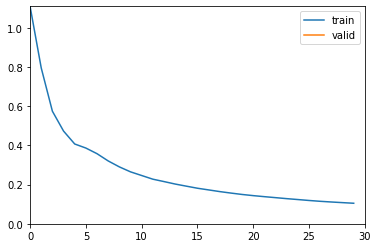

epoch,train_loss,valid_loss,foreground_acc,time
0,0.031408,0.046522,0.000000,00:28
1,0.024753,0.055471,0.008661,00:28
2,0.020168,0.046269,0.058403,00:28
3,0.016470,0.045684,0.071381,00:28
4,0.014631,0.076420,0.033580,00:28
5,0.013613,0.035763,0.239317,00:28
6,0.012299,0.044977,0.195386,00:28
7,0.011234,0.027437,0.366961,00:28
8,0.010572,0.022844,0.395042,00:28
9,0.009708,0.019495,0.442780,00:28


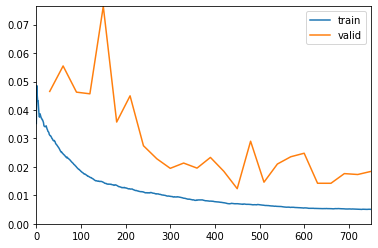

In [5]:
no_norm_learner = unet_learner(dls, resnet34, cbs=ShowGraphCallback(), metrics=[foreground_acc])
no_norm_learner.fine_tune(25)

## Conclusions from the train-validation curves

The training curve above shows the model performance over time as measured by the loss, where lower values are better. The model performs well on the training data, these are the data the model actually learns from, but the validation results are poorer and more erratic. This suggests that what the model is learning is not generalizable to new data, that the model has only memorized what it has already seen without learning the underlying features.

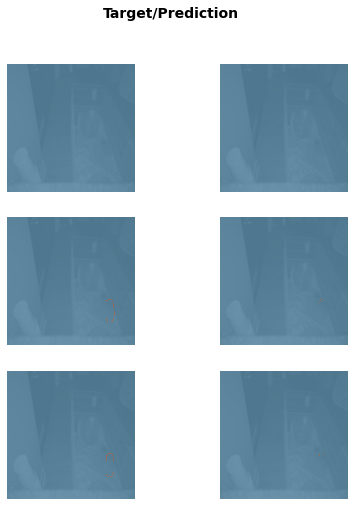

In [6]:
no_norm_learner.show_results(max_n=3, figsize=(7,8))

In [19]:
This becomes more clear when we look at predictions on data the model has never seen before. We see that the model often completely misses Xiaomi!

SyntaxError: invalid syntax (<ipython-input-19-cb2ef7eda6b6>, line 1)

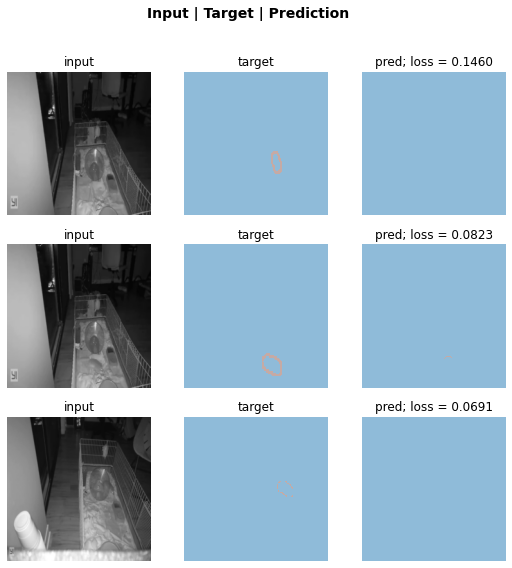

In [7]:
interp = SegmentationInterpretation.from_learner(no_norm_learner)
interp.plot_top_losses(k=3)

In [8]:
test_images = get_image_files(test_path / 'images')
print(len(test_images), 'test images')

13 test images


In [9]:
import matplotlib.pyplot as plt

from hedgiefinder import HedgieFinder
from hedgiefinder.inference import alpha_mask
from scipy.ndimage.interpolation import zoom

In [12]:
def show_overlay(learner, test_im, fname=None):
    original = plt.imread(test_im)
    pred_small = learner.predict(test_im)[0]
    pred = zoom(pred_small, np.array(original.shape[:-1])/np.array(pred_small.shape))
    overlay = alpha_mask(original, pred)

    f, axs = plt.subplots(1,1, figsize=(16,16))
    axs.imshow(overlay)
    if fname:
        plt.savefig(fname)
    plt.show()
    return overlay

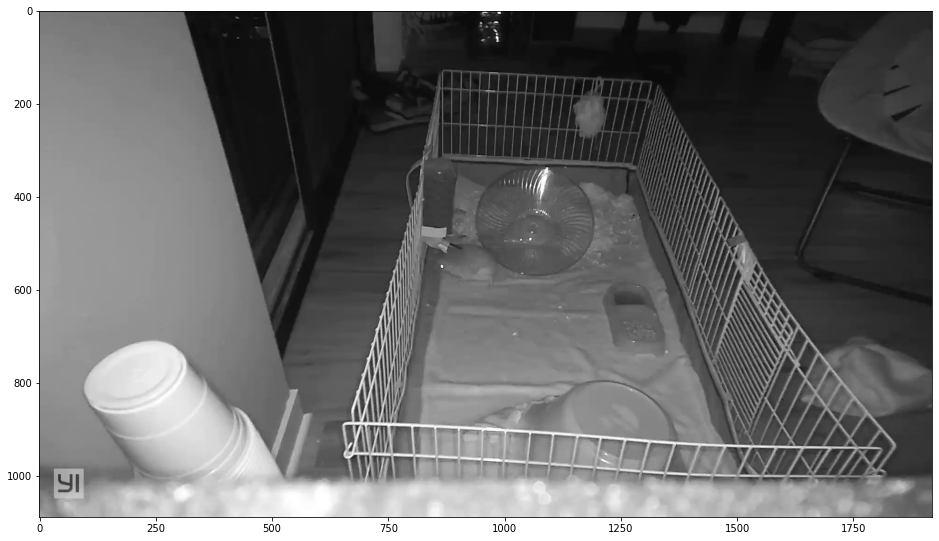

In [13]:
test_im = test_images[0]
no_norm_im = show_overlay(no_norm_learner, test_im, 'no_norm.png')

## Now add imagenet normalization

Much of the fastai book is concerned with avoiding overfitting, which is exactly the issue we are dealing with here. The model memorizes the training set, but doesn't perform well on new images, as shown above, the model completely misses Xiaomi! [Chapter 7 of Fastbook](https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb) introduces several powerful means to avoid overfitting. The first that we'll incorporate here is **normalization**. As the book states, normalization is especially important when using pretrained models (which we are using in our Hog Finder model! resnet34). Transfer learning with pretrained models is one of the only practical means to implement deep learning because you don't need lots of training data, you benefit from the previous training done by the original model trainers who have more resources, time, and expertise to pretrain excellent models. Transfer learning is a major theme of fastai and key to what makes deep learning accessible outside of the ivory towers of big corporations. With that in mind, normalization enables us to better utilize existing models by formatting our data to fall within the range of values that the pretrained model has already seen.

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


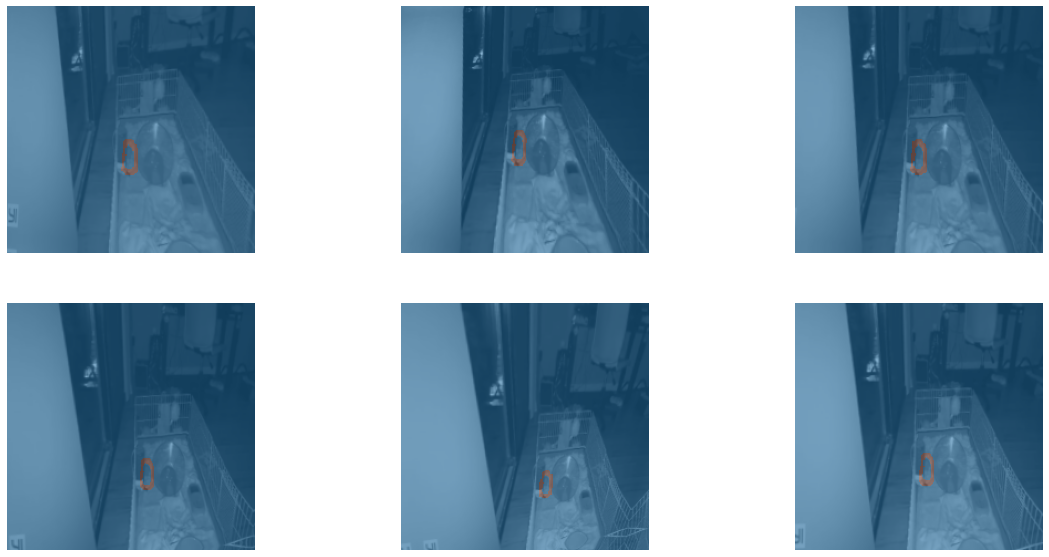

In [14]:
dls = get_dls_norm(8, 224)
dls.show_batch(max_n=6, unique=True, figsize=(20,10))

epoch,train_loss,valid_loss,foreground_acc,time
0,0.100900,0.042302,0.000000,01:12


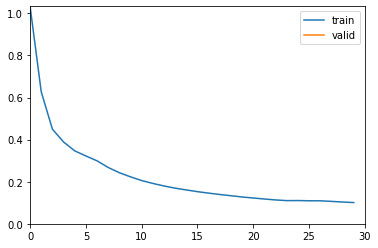

epoch,train_loss,valid_loss,foreground_acc,time
0,0.030947,0.026831,0.000000,01:49
1,0.025020,0.021435,0.296620,01:02
2,0.020713,0.027102,0.283523,01:01
3,0.017871,0.014639,0.442285,01:08
4,0.015519,0.011401,0.596701,00:58
5,0.015156,0.012144,0.557329,00:58
6,0.012911,0.009960,0.707732,00:58
7,0.011900,0.011976,0.598565,00:58
8,0.010406,0.009697,0.711378,00:58
9,0.009461,0.008928,0.704192,00:57


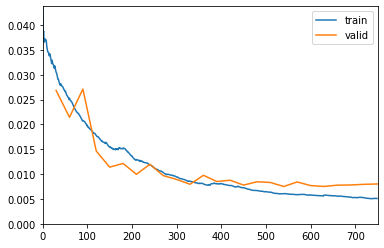

In [15]:
norm_learner = unet_learner(dls, resnet34, cbs=ShowGraphCallback(), metrics=[foreground_acc])
norm_learner.fine_tune(25)

## The addition of ImageNet normalization made a huge difference!!

With the simple addition of ImageNet normalization, we see that the validation curve better follows the training loss curve, meaning that what the model is learning is generalizable to other data. In addition the model accuracy is 10-20 percentage points higher than before! 73% vs 53%!

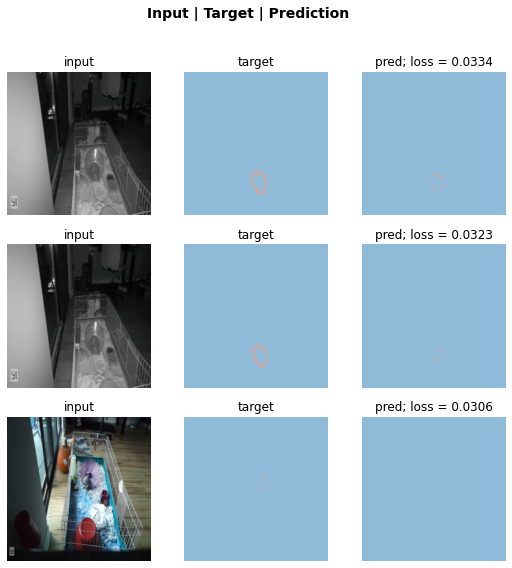

In [16]:
interp = SegmentationInterpretation.from_learner(norm_learner)
interp.plot_top_losses(k=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


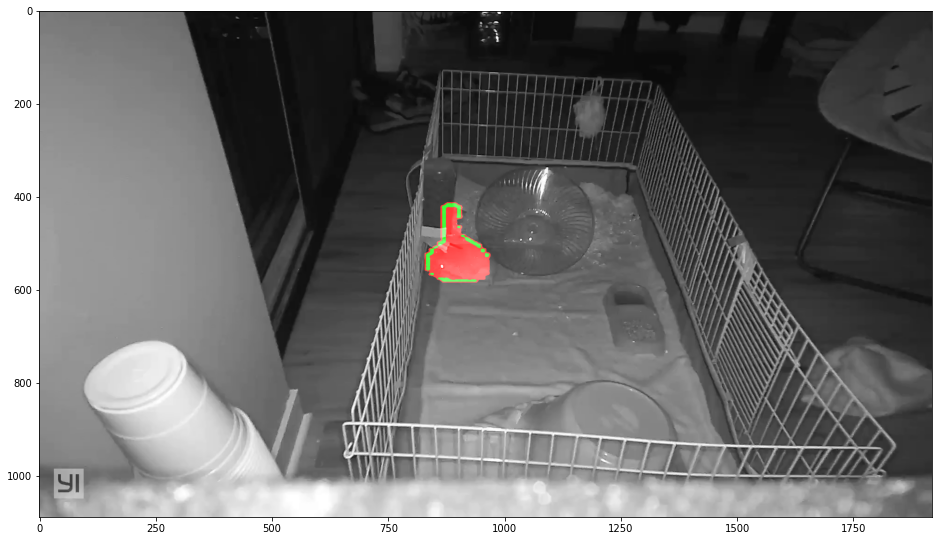

In [17]:
norm_im = show_overlay(norm_learner, test_im, 'norm.png')

It found her!

## How does the model generalize to other hedgehogs?

- instagram hogs...

### Explore Progressize resizing

In [18]:
save_model = False

from datetime import datetime
model_path = path.parent.parent / 'hedgiefinder' / 'models'
model_name = model_path / datetime.now().strftime("%Y%m%d_%H%M.pkl")

if save_model:
    model_dir = model_name.parent
    model_dir.mkdir(exist_ok=True)

    norm_learner.export(model_name)
    print(model_name)